In [1]:
# oemof tabular

In [2]:
import os
import pkg_resources as pkg
import pandas as pd
import numpy as np 
from pyomo.opt import SolverFactory
import pyomo.environ as po 
from oemof.solph import EnergySystem, Model, Bus
from oemof.tools.economics import annuity as annuity
from oemof.solph import constraints
import oemof.tabular.tools.postprocessing as pp
import oemof.tabular.facades as fc

In [3]:
scenario = "base_demand_2036_evl_2_cruise_24hr_AZ" 
# name of the scenario and the corresponding file, e.g. "A.xls" 
country = "barbados"


## Creating and Setting the Datapaths

First, the datapath for raw-data and results is set. Data handling looks more complex than it is. You can easily adapt this to a simple `pd.read_excel(filepath,...)` in the next block if your file is located somewhere else. Otherwise we will use data from the repository repository. 

In addition a results directory will be created in `home/user/oemof-results/results/<scenario-name>/output`. 

In [4]:
# datapath for input data from the oemof tabular pacakge
datapath = os.path.join(
    os.getcwd(),#pkg.resource_filename("oemof.jordan", ""),
    "data", 
    scenario + ".xls",
)

carrier_technology_path = os.path.join(
    os.getcwd(), 
    "data",
    "carrier-technology.xls"
)

# results path
results_path = os.path.join(
    os.path.expanduser("~"), "oemof-results", country,
)

scenario_path = os.path.join(
    results_path, scenario, "output"
)

if not os.path.exists(scenario_path):
    os.makedirs(scenario_path)

Next the required input data will be read. The profiles index will be used for the `EnergySystem` object below. 
All generator data etc. will also be loaded. 

In [5]:
file = pd.ExcelFile(datapath)

sheet_names = [typ for typ in file.sheet_names if typ in fc.TYPEMAP.keys()]

data = {}

for sheet in sheet_names: 
    data[sheet]= pd.read_excel(datapath, sheet_name=sheet, index_col=0)

# profiles and tech data not be part of TYPEMAP and need to be read seperately
profiles = pd.read_excel(
    datapath,
    sheet_name="profiles",
    index_col=[0],
    parse_dates=True,
)
profiles.index.freq = "1H"

technology = pd.read_excel(
    carrier_technology_path, sheet_name="technology-data", index_col=[0, 1, 2]
)
carrier = pd.read_excel(
    carrier_technology_path, sheet_name="carrier", index_col=[0, 1]
)

if "co2-limit" in file.sheet_names:
    co2_limit = pd.read_excel(datapath, sheet_name="co2-limit", index_col=0)
else: 
    co2_limit = None


In [6]:
# What is the significance of saying CO2 limit here in the model? 
# What does this statement mean? 

In [7]:
all_components = pd.concat([v for k, v in data.items() if k not in ["bus", "co2-limit"]], sort=False)
# Only be used for Latex export of tables 
#columns = ['profile', 'capacity_potential']
#print(all_components.to_latex(columns=columns, na_rep="-"))

In [8]:
def _capacity_cost(g, scenario=scenario):
    if bool(g["expandable"]):
        val = annuity(
            technology.at[(g["carrier"], g["tech"], scenario), "capex"], 
            technology.at[(g["carrier"], g["tech"], scenario), "lifetime"],
            technology.at[(g["carrier"], g["tech"], scenario), "wacc"]) * (
            (1 + (technology.at[(g["carrier"], g["tech"], scenario), "fom"])
            )) 
        return val * 1000 # $/kw -> $/MW
    else:
        return None
    
def _marginal_cost(g, scenario):
    if not isinstance(g, dict):
        g = g.to_dict()
    if not pd.isna(g.get("marginal_cost", np.nan)):
        return g["marginal_cost"]
    else:
        return (carrier.at[(g["carrier"], scenario), "cost"] / g["efficiency"])
    
def _none(number):
    if pd.isna(number):
        return None
    else:
        return number

## Creating the EnergySystem and its Nodes

Firs, an `EnergySystem` object will be created. This holds all information (nodes, etc.) of the modelled energy system that will be added below. This is just the standard way of using the `oemof.solph` library for your modelling.

In [9]:
es = EnergySystem(timeindex=profiles.index)

### Buses

Before any components are added, all bus objects are added to the energy system object.

In [10]:
buses = {
    name: Bus(label=name, balanced=bool(arg.balanced))
    for name, arg in data["bus"].iterrows()
}
es.add(*buses.values())


#### Bus Constraints 

With the set of all Buses $B$ all inputs $x^{flow}_{i(b),b}$ to a bus $b$ must equal all its outputs $x^{flow}_{b,o(b)}$

$$\sum_i x^{flow}_{i(b), b}(t) - \sum_o x^{flow}_{b, o(b)}(t) = 0 \qquad \forall t \in T, \forall b \in B$$

This equation will be build once the complete energy system is setup with its components. Every time a `Component` is created, the connected bus inputs/outputs will be updated. By this update every bus has all required information of its inputs and outputs available to construct the constraints. 


### Load components

#### Load Constraint 

For the set of all Load denoted with $l \in L$ the load $x_l$ at timestep t equals the exogenously defined  profile value $c^{profile}_l$ multiplied by the amount of this load $c^{amount}_l$

$$ x^{flow}_{l}(t) = c^{profile}_{l}(t) \cdot c^{amount}_{l} \qquad \forall t \in T, \forall l \in L$$

In [11]:
for name, l in data["load"].iterrows():
    es.add(
        fc.Load(
            label=name,
            bus=buses[
                l.bus
            ],  # reference the bus in the buses dictionary
            amount=l.amount,  # amount column
            profile=profiles[l.profile],
        )
    )


/home/g61/Projects/oemof-barbados/oemof-barbados-env/lib/python3.7/site-packages/oemof/solph/network.py:250: SuspiciousUsageWarning: `Sink` 'BB_el_load' constructed without `inputs`.
  warn(msg.format(self), debugging.SuspiciousUsageWarning)
/home/g61/Projects/oemof-barbados/oemof-barbados-env/lib/python3.7/site-packages/oemof/solph/network.py:250: SuspiciousUsageWarning: `Sink` 'BB_ev_10,000' constructed without `inputs`.
  warn(msg.format(self), debugging.SuspiciousUsageWarning)
/home/g61/Projects/oemof-barbados/oemof-barbados-env/lib/python3.7/site-packages/oemof/solph/network.py:250: SuspiciousUsageWarning: `Sink` 'BB_cruise_24hr_load' constructed without `inputs`.
  warn(msg.format(self), debugging.SuspiciousUsageWarning)


### Dispatchable and Volatile component

#### Dispatchable Generator Constraint

A `Dispatachble` component can be used to model all types of dispatchble units in a energy system. This can include diesel generators oder coal fired power plants but also hot water boilers for heat. Every generator **must** be connected to an `Bus` object. 

This basic mathematical model for the component with the set of all dispatchable generators being $d \in D$ looks as follows:

$$x^{flow}_{d}(t) \leq c^{capacity}_{d} \qquad \forall t \in T,  \forall d \in D$$

Meaning, the production of the generator $x^{flow}$ must be less than its maximum capacity $c^{capacity}_d$ in every timestep. *Note that this equation holds for the case where the `expandable` attribute is set to `False`*. For the investment case the following two equation hold:

$$x^{flow}_{d}(t) \leq x^{capacity}_{d} \qquad \forall t \in T,  \forall d \in D$$
$$c^{capacity}_d \leq x^{capacity}_{d} \leq c^{capacity\_potential}_{d} \forall d \in D$$


In [12]:
for name, g in data["dispatchable"].iterrows():
    g = g.to_dict()
    es.add(
        fc.Dispatchable(
            label=name,
            bus=buses[g["bus"]],
            carrier=g["carrier"],
            tech=g["tech"],
            marginal_cost=_marginal_cost(g, scenario),
            expandable=g.get("expandable", False),
            capacity=g["capacity"],
            capacity_potential=None,
            capacity_cost=_capacity_cost(g, scenario),
            output_parameters={
                "emission_factor": (
                    carrier.at[(g["carrier"], scenario), "emission_factor"]
                    / g["efficiency"]
                )
            },
        )
    )

/home/g61/Projects/oemof-barbados/oemof-barbados-env/lib/python3.7/site-packages/oemof/solph/network.py:263: SuspiciousUsageWarning: `Source` 'BB_ccgt' constructed without `outputs`.
  warn(msg.format(self), debugging.SuspiciousUsageWarning)
/home/g61/Projects/oemof-barbados/oemof-barbados-env/lib/python3.7/site-packages/oemof/solph/network.py:263: SuspiciousUsageWarning: `Source` 'BB_gt' constructed without `outputs`.
  warn(msg.format(self), debugging.SuspiciousUsageWarning)


#### Volatile Generator Constraint

For the `Volatile` $v \in V$ generators that can be used to model PV and Wind units the flow will be fixed by a given profile multiplied with the (optimised) capacity $x^{capacity}_{v}$ in the investment case and the exougenously defined capacity $c^{capacity}_{v}$ in the non-investment case (i.e. `expandable` attribute `False`). 

$$ x^{flow}_{v}(t) = c^{profile}_{v}(t) \cdot x^{capacity}_{v} \qquad \forall t \in T, \forall v \in V$$

The optimised capacity is limited by the following variable bounds:

$$c^{capacity}_v \leq x^{capacity}_{v} \leq c^{capacity\_potential}_{v} \forall v \in V$$


In [13]:
for name, v in data["volatile"].iterrows():
    es.add(
        fc.Volatile(
            label=name,
            bus=buses[v.bus],
            carrier=v.carrier,
            tech=v.tech,
            expandable=v.expandable,
            capacity=v.capacity,
            capacity_minimum=v.capacity_minimum,
            capacity_potential=v.capacity_potential,
            capacity_cost=_capacity_cost(v, scenario),
            profile=profiles[v.profile],
        )
    )


/home/g61/Projects/oemof-barbados/oemof-barbados-env/lib/python3.7/site-packages/oemof/solph/network.py:263: SuspiciousUsageWarning: `Source` 'BB_pv_distributed' constructed without `outputs`.
  warn(msg.format(self), debugging.SuspiciousUsageWarning)
/home/g61/Projects/oemof-barbados/oemof-barbados-env/lib/python3.7/site-packages/oemof/solph/network.py:263: SuspiciousUsageWarning: `Source` 'BB_pv_utiltiy' constructed without `outputs`.
  warn(msg.format(self), debugging.SuspiciousUsageWarning)
/home/g61/Projects/oemof-barbados/oemof-barbados-env/lib/python3.7/site-packages/oemof/solph/network.py:263: SuspiciousUsageWarning: `Source` 'BB_wind_onshore_1' constructed without `outputs`.
  warn(msg.format(self), debugging.SuspiciousUsageWarning)
/home/g61/Projects/oemof-barbados/oemof-barbados-env/lib/python3.7/site-packages/oemof/solph/network.py:263: SuspiciousUsageWarning: `Source` 'BB_wind_onshore_2' constructed without `outputs`.
  warn(msg.format(self), debugging.SuspiciousUsageWarni

### Storage components

In [14]:
for name, s in data["storage"].iterrows():
    s = s.to_dict()
    es.add(
        fc.Storage(
            label=name,
            bus=buses[s["bus"]],
            carrier=s["carrier"],
            tech=s["tech"],
            marginal_cost=s["marginal_cost"],
            capacity=s["capacity"],
            storage_capacity=s["storage_capacity"],
            storage_capacity_potential=s["storage_capacity_potential"],
            min_storage_level=s.get("min_storage_level", 0),
            expandable=s["expandable"],
            efficiency=s["efficiency"],
            loss_rate=s["loss_rate"],
            initial_storage_level=s["initial_storage_level"],
            invest_relation_output_capacity=_none(s.get("invest_relation_output_capacity")),
            invest_relation_input_capacity=_none(s.get("invest_relation_input_capacity")),
            storage_capacity_cost=annuity(
                technology.at[
                    (s["carrier"], s["tech"], scenario), "storage_capex"
                ],
                technology.at[
                    (s["carrier"], s["tech"], scenario), "lifetime"
                ],
                 technology.at[
                    (s["carrier"], s["tech"], scenario), "wacc"
                ],
            )
            * 1000,  # $/kW -> $/MW
            capacity_cost=_capacity_cost(s, scenario)
    )
)

#### Storage Constraints 

The mathematical representation of the storage for all storages $s \in S$ will include the flow into the storage, out of the storage and a storage level. The default efficiency for input/output is 1. Note that the provided efficiency is applied for charge and discharge. Hence, if you want to set the round trip efficiency you need to set $\eta = \sqrt{\eta^{roundtrip}}$, where $\eta$ is the efficiency provided to construct the component. 

Intertemporal energy balance of the storage:

$$ x^{level}_{s}(t) = (1-\eta^{loss\_rate}) x^{level}_{s}(t) + \eta_{in} x^{flow}_{s, in} - \frac{x^{flow}_{s, out}(t)}{\eta_{out}} \qquad \forall t \in T,  \forall s \in S$$ 

Bounds of the storage level variable $x^{level}_s(t)$ with investment. The first and the last timestep are linked and set to a fixed value (e.g. 0.5 of the maximum storage capacity)

$$ x^{level}_s(1) = x_s^{level}(t_{e}) = 0.5 \cdot \overline{x}_s^{level} \qquad \forall t \in T,  \forall s \in S$$ 

Additionally, the level is bounded by the optimised storage capacity (energy) $\overline{x}_s^{level}$:

$$ x^{level}_s(t) \leq \overline{x}_s^{level} \qquad \forall t \in T, \forall s \in S$$ 

The investment itself is limited by parameters of the existing storage capacity and its potential: 

$$ c_s^{storage\_capacity} \leq \overline{x}_s^{level} \leq c_s^{storage\_capacity\_potential} $$

The inflow/outflow (i.e. power) of the storage also needs to be within the limit of the minimum and maximum power. 

$$ -x_s^{capacity} \leq x^{flow}_s(t) \leq x_s^{capacity} \qquad \forall t \in T, \forall s \in S$$ 

The investment in capacity is again bounded. Similary to the bounds of the storage capacity it is limited by the existing capacity and the capacity potential.

$$ c_s^{capacity} \leq x_s^{capacity} \leq c_s^{capacity\_potential} $$



### Conversion component

A conversion unit will take from a bus and feed into another: 

$$x^{flow}_{c, to}(t) = c^{efficiencty}_{c} \cdot x^{flow}_{c, from}(t), \qquad \forall c  \in C, \forall t \in T$$ 

For the non-investment case the outflow, i.e. the flow **to** the bus where the conversion unit is connected with its output the following constraint applies:

$$x^{flow}_{c, to} \leq c^{capacity}_c$$

In the case of investment compare constraints from the volatile generator units.

In [15]:
for name, c in data["conversion"].iterrows():
    es.add(
        fc.Conversion(
            label=name,
            from_bus=buses[c.from_bus],
            to_bus=buses[c.to_bus],
            carrier=c.carrier,
            tech=c.tech,
            efficiency=c.efficiency,
            marginal_cost=c.vom,
            carrier_cost=carrier.at[(c.carrier, scenario), "cost"],
            expandable=c.expandable,
            capacity=c.capacity,
            capacity_potential=c.capacity_potential,
            capacity_cost=_capacity_cost(c, scenario),
            output_parameters={
                "emission_factor": (
                    carrier.at[(c.carrier, scenario), "emission_factor"]
                    / c.efficiency)
            },
        )
    )


/home/g61/Projects/oemof-barbados/oemof-barbados-env/lib/python3.7/site-packages/oemof/solph/network.py:323: SuspiciousUsageWarning: `Transformer` 'BB_bagasse_ce' constructed without `inputs`.
  warn(msg.format(self), debugging.SuspiciousUsageWarning)
/home/g61/Projects/oemof-barbados/oemof-barbados-env/lib/python3.7/site-packages/oemof/solph/network.py:326: SuspiciousUsageWarning: `Transformer` 'BB_bagasse_ce' constructed without `outputs`.
  warn(msg.format(self), debugging.SuspiciousUsageWarning)


### Commodity components

For the commodity components, the aggregated flow for the complete time horizon is limited by the user defined amount:
$$ \sum_t x^{flow}_k(t) \leq c^{amount} \qquad \forall k \in K$$

In [16]:
for name, c in data["commodity"].iterrows():
    es.add(
        fc.Commodity(
            label=name,
            bus=buses[c.bus],
            carrier=c.carrier,
            tech=c.tech,
            amount=c.amount,
        )
    )


/home/g61/Projects/oemof-barbados/oemof-barbados-env/lib/python3.7/site-packages/oemof/solph/network.py:263: SuspiciousUsageWarning: `Source` 'BB_bagasse_commodity' constructed without `outputs`.
  warn(msg.format(self), debugging.SuspiciousUsageWarning)


### Link components

The link components allows to model energy transfer from one bus to an other. For example transhipment modelling approach can be used for transmission in electricity systems. The equation for a line $n$ is considering a loss within the transfer process $from$ a bus $to$ the other bus.

$$x^{flow}_{from, n}(t) = c^{loss}_{n} \cdot x^{flow}_{n, to}(t), \qquad \forall n  \in N, \forall t \in T$$

In [17]:
for name, c in data["link"].iterrows():
    es.add(
        fc.Link(
            label=name,
            from_bus=buses[c.from_bus],
            to_bus=buses[c.to_bus],
            capacity=c.capacity,
            expandable=c.expandable,
             capacity_cost=annuity(
                technology.at[(c.carrier, c.tech, scenario), "capex"],
                technology.at[
                    (c.carrier, c.tech, scenario), "lifetime"
                ],
                technology.at[
                    (c.carrier, c.tech, scenario), "wacc"
                ],
            )
            * 1000,  # $/kW -> $/MW
            loss=c.loss
        )
    )

### Objective Function 

The objective function is created from all instantiated objects. It will use all operating costs (i.e. `marginal_cost` argument) and if set all investment costs (i.e. `capacity_cost` argument) for all generators (dispatchable and volatile, conversion units and storages). In addition the energy related storage costs are added.  

$$ \text{min:} \sum_g \sum_t \overbrace{c^{marginal\_cost}_g \cdot x^{flow}_{g}(t)}^{\text{operating cost}} \\ 
\sum_g \sum_t \overbrace{c^{capacity\_cost}_g \cdot x^{capacity}_{g}(t)}^{\text{investment cost}} + \\
\sum_s \overbrace{c^{storage\_capacity\_cost}_s \cdot \overline{x}^{storage\_capacity}_{s}(t)}^{\text{storage energy cost}}$$

### Add Shortage/Excess Slack Components

If these are added, additional cost will occur inside the objective function. Shortage / Excess can be understood as a very expensive generator or load repectively. 

In [18]:
for name, e in data["excess"].iterrows():
    es.add(fc.Excess(label=name, bus=buses[e.bus]))

for name, s in data["shortage"].iterrows():
    es.add(
        fc.Shortage(
            label=name,
            carrier="electricity",
            tech="shortage",
            bus=buses[s.bus],
            marginal_cost=s.marginal_cost,
        )
    )


/home/g61/Projects/oemof-barbados/oemof-barbados-env/lib/python3.7/site-packages/oemof/solph/network.py:250: SuspiciousUsageWarning: `Sink` 'BB_el_excess' constructed without `inputs`.
  warn(msg.format(self), debugging.SuspiciousUsageWarning)
/home/g61/Projects/oemof-barbados/oemof-barbados-env/lib/python3.7/site-packages/oemof/solph/network.py:263: SuspiciousUsageWarning: `Source` 'BB_el_shortage' constructed without `outputs`.
  warn(msg.format(self), debugging.SuspiciousUsageWarning)


## Creating the Mathematical Model

In [19]:
# create model based on energy system and its components
m = Model(es)

### Add CO2 Constraint

To add a CO2-constraint we will use the `oemof.solph.constraints` module which allows to add such a constraint in a easy way. 

$$ \sum_t \sum_f  x^{flow}_f(t) \cdot c^{emission\_factor}_f \leq \overline{L_{CO_2}} $$

The constraint will sum all flows for the complete time horzion that have an attribute `emission_factor` and multiple the flow value with this factor. 

In [20]:
if co2_limit is not None:
    constraints.generic_integral_limit(m, keyword='emission_factor', limit=co2_limit.loc["BB_el", "value"])
#m.write(io_options={"symbolic_solver_labels":True})

In [21]:
def _excess_limit(m):
    lhs = sum(m.flow[es.groups["BB_el"], es.groups["BB_el_excess"], t] for t in m.TIMESTEPS)
    rhs = data["load"].loc["BB_el_load", "amount"]
    return (lhs <= rhs * 0.1)
m.excess_limit = po.Constraint(rule=_excess_limit) 

In [22]:
m.excess_limit.expr

In [23]:
m.receive_duals()

    with a new Component with type <class 'pyomo.core.base.suffix.Suffix'>.
    This is usually indicative of a modelling error. To avoid this warning,
    explicitly delete the attribute:
        del Model.dual
    with a new Component with type <class 'pyomo.core.base.suffix.Suffix'>.
    This is usually indicative of a modelling error. To avoid this warning,
    explicitly delete the attribute:
        del Model.rc


## Solving the Model and Writing Results

In [24]:
# check if cbc solver library is available
cbc = SolverFactory('cbc').available()

if cbc:
    #  solve the model using cbc solver
    m.solve("cbc", tee=True)

    # write results back to the model object
    m.results = m.results()

    # writing results with the standard oemof-tabular output formatt
    pp.write_results(m, m.results, scenario_path)
    
    if co2_limit is not None:
        pd.Series(
            [(m.integral_limit_emission_factor_constraint() / 1e6), 
             m.dual[m.integral_limit_emission_factor_constraint], 
             m.objective()],
            index=["CO2 (Mio. t)", "Shadow Price in $/t", "Objective value"]
        ).to_csv(os.path.join(scenario_path, "costs.csv"))
    else: 
        pd.Series(
            [m.objective()],
            index=["Objective value"]
        ).to_csv(os.path.join(scenario_path, "costs.csv"))
    
    print(
        "Optimization done. Results are in {}.".format(
            results_path
        )
    )

Optimization done. Results are in /home/g61/oemof-results/barbados.


In [25]:
m.write(io_options={"symbolic_solver_labels": True})

('Model.lp', 140422373140408)

### Print CO2-results

In [26]:
if co2_limit is not None:
    print("Emissions in Mio t: " + str(m.integral_limit_emission_factor_constraint() / 1e6))
    print("Shadow price of CO2: " + str(m.dual[m.integral_limit_emission_factor_constraint]))

Emissions in Mio t: 0.050000000090587825
Shadow price of CO2: -560.39396


## Optional sensitivity calculations

To use this, adapt to your needs. 

In [27]:
if False:
    co2_base = m.integral_limit_emission_factor_constraint() # take as base for emissions
    sensitivities = [1]
    for co2_reduction in sensitivities:
        sensitivity_path = scenario_path.replace("-0", "-" + str(int(100 - co2_reduction * 100)))
        
        if not os.path.exists(sensitivity_path):
            os.makedirs(sensitivity_path)
        
        m = Model(es)
        constraints.generic_integral_limit(
            m, keyword='emission_factor', 
            limit=co2_reduction * co2_base)
        
        m.receive_duals()

        m.solve("gurobi")

        m.results = m.results()

        pp.write_results(m, m.results, sensitivity_path)
        
        pd.Series(
            [(m.integral_limit_emission_factor_constraint() / 1e6), 
             m.dual[m.integral_limit_emission_factor_constraint], 
             m.objective()],
            index=["CO2 (Mio. t)", "Shadow Price in $/t", "Objective value"]

        ).to_csv(os.path.join(sensitivity_path, "costs.csv"))

## Visualization

Text(0, 0.5, 'Installed capacity in MW')

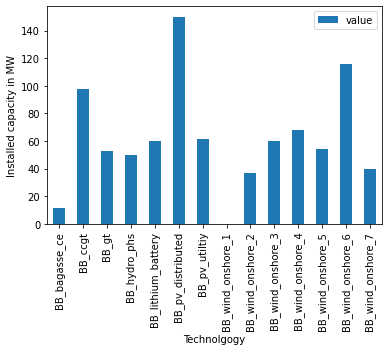

In [28]:
capacities = pd.read_csv(os.path.join(scenario_path, "capacities.csv"), index_col=[0,1,2,3,4])
ax = capacities.xs(("BB_el", "invest"), level=[1,2]).droplevel([1,2]).plot(kind="bar", rot=90)
ax.set_xlabel("Technolgogy")
ax.set_ylabel("Installed capacity in MW")

In [29]:
pd.read_csv(os.path.join(scenario_path, "capacities.csv"), index_col=[0,1,2,3,4])

value
from               to                 type     tech       carrier            
BB_bagasse_ce      BB_el              invest   ce         bagasse   11.288181
BB_ccgt            BB_el              invest   ccgt       gas       97.884371
BB_el              BB_hydro_phs       invest   NaN        NaN       50.000000
                   BB_lithium_battery invest   NaN        NaN       59.767965
BB_gt              BB_el              invest   gt         gas       52.706786
BB_hydro_phs       BB_el              invest   phs        hydro     50.000000
BB_lithium_battery BB_el              invest   battery    lithium   59.767965
BB_pv_distributed  BB_el              invest   pv         solar    150.000000
BB_pv_utiltiy      BB_el              invest   pv-utility solar     61.409320
BB_wind_onshore_1  BB_el              invest   onshore_1  wind       0.000000
BB_wind_onshore_2  BB_el              invest   onshore_2  wind      36.915897
BB_wind_onshore_3  BB_el              invest   onshore_3  wind      60.000000
BB_wind_onshore_4  BB_el              invest   onshore_4  wind      68.000000
BB_wind_onshore_5  BB_el              invest   onshore_5  wind      54.000000
BB_wind_onshore_6  BB_el              invest   onshore_6  wind     116.000000
BB_wind_onshore_7  BB_el              invest   onshore_7  wind      40.000000
BB_ccgt            BB_el              capacity ccgt       gas        0.000000
BB_gt              BB_el              capacity gt         gas        0.000000
BB_pv_distributed  BB_el              capacity pv         solar      0.000000
BB_pv_utiltiy      BB_el              capacity pv-utility solar      0.000000
BB_wind_onshore_1  BB_el              capacity onshore_1  wind       0.000000
BB_wind_onshore_2  BB_el              capacity onshore_2  wind       0.000000
BB_wind_onshore_3  BB_el              capacity onshore_3  wind       0.000000
BB_wind_onshore_4  BB_el              capacity onshore_4  wind       0.000000
BB_wind_onshore_5  BB_el              capacity onshore_5  wind       0.000000
BB_wind_onshore_6  BB_el              capacity onshore_6  wind       0.000000
BB_wind_onshore_7  BB_el              capacity onshore_7  wind       0.000000
BB_lithium_battery BB_el              capacity battery    lithium    0.000000
BB_hydro_phs       BB_el              capacity phs        hydro      0.000000
BB_bagasse_ce      BB_el              capacity ce         bagasse    0.000000

<AxesSubplot:xlabel='timeindex'>

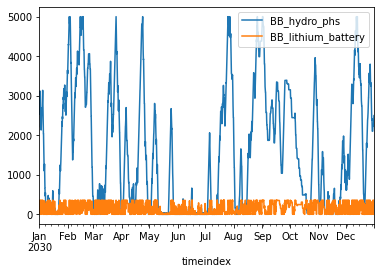

In [30]:
filling = pd.read_csv(os.path.join(scenario_path, "filling_levels.csv"), index_col=[0], parse_dates=True)
filling.plot()

Text(0, 0.5, 'Enegy in Gwh')

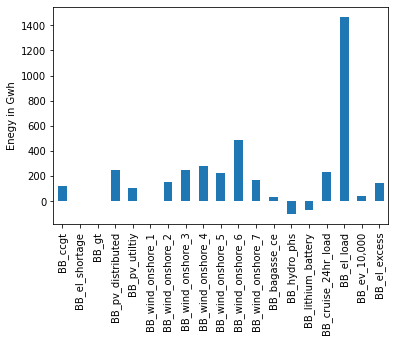

In [31]:
balance = pd.read_csv(os.path.join(scenario_path, "BB_el.csv"), index_col=[0], parse_dates=True)
ax = (balance.sum() / 1e3).plot(kind="bar",rot=90)
ax.set_ylabel("Enegy in Gwh")

In [32]:
sums = balance.sum() / 1e6
re_share = (
    sums["BB_wind_onshore_1"] +
    sums["BB_wind_onshore_2"] +
    sums["BB_wind_onshore_3"] +
    sums["BB_wind_onshore_4"] +
    sums["BB_wind_onshore_5"] +
    sums["BB_wind_onshore_6"] +
    sums["BB_wind_onshore_7"] +
    sums["BB_pv_utiltiy"] + 
    sums["BB_pv_distributed"] + 
    sums["BB_bagasse_ce"] - 
    sums["BB_el_excess"]
    ) / sums["BB_el_load"]
print(re_share)

1.2240127310901892


In [33]:
sums["BB_el_load"]

1.4678417936294714

In [34]:
m.objective() / ((sums["BB_el_load"] + 
                  sums["BB_ev_10,000"]  + 
                  sums["BB_cruise_24hr_load"]- sums["BB_el_excess"]) *1e6)


67.3390377937239